# FMAML (Microsoft suit)

* Synthetic data (Faker)
* Automatic selection and plotting of relevant features

✅ FLAML AutoML library loaded successfully
⚠️ Auto-sklearn not available. Install with: pip install auto-sklearn
✅ TPOT AutoML library loaded successfully
Initializing Advanced Fraud Detection AutoML System...
Generating new fraud detection dataset...
Dataset loaded: 500 samples
Fraud cases: 50
Fraud ratio: 10.00%

🔧 Performing Advanced Feature Engineering...
    Creating advanced features...
    ✅ Created 27 new features
    Total features: 38

🎯 Performing Intelligent Feature Selection...
    📊 Running univariate statistical tests...
    🔗 Computing mutual information scores...
    🌳 Computing Random Forest feature importance...
    🔄 Running Recursive Feature Elimination...
    ⚖️  Combining feature selection methods...
    ✅ Selected 14 best features
    📈 Creating feature selection visualization...


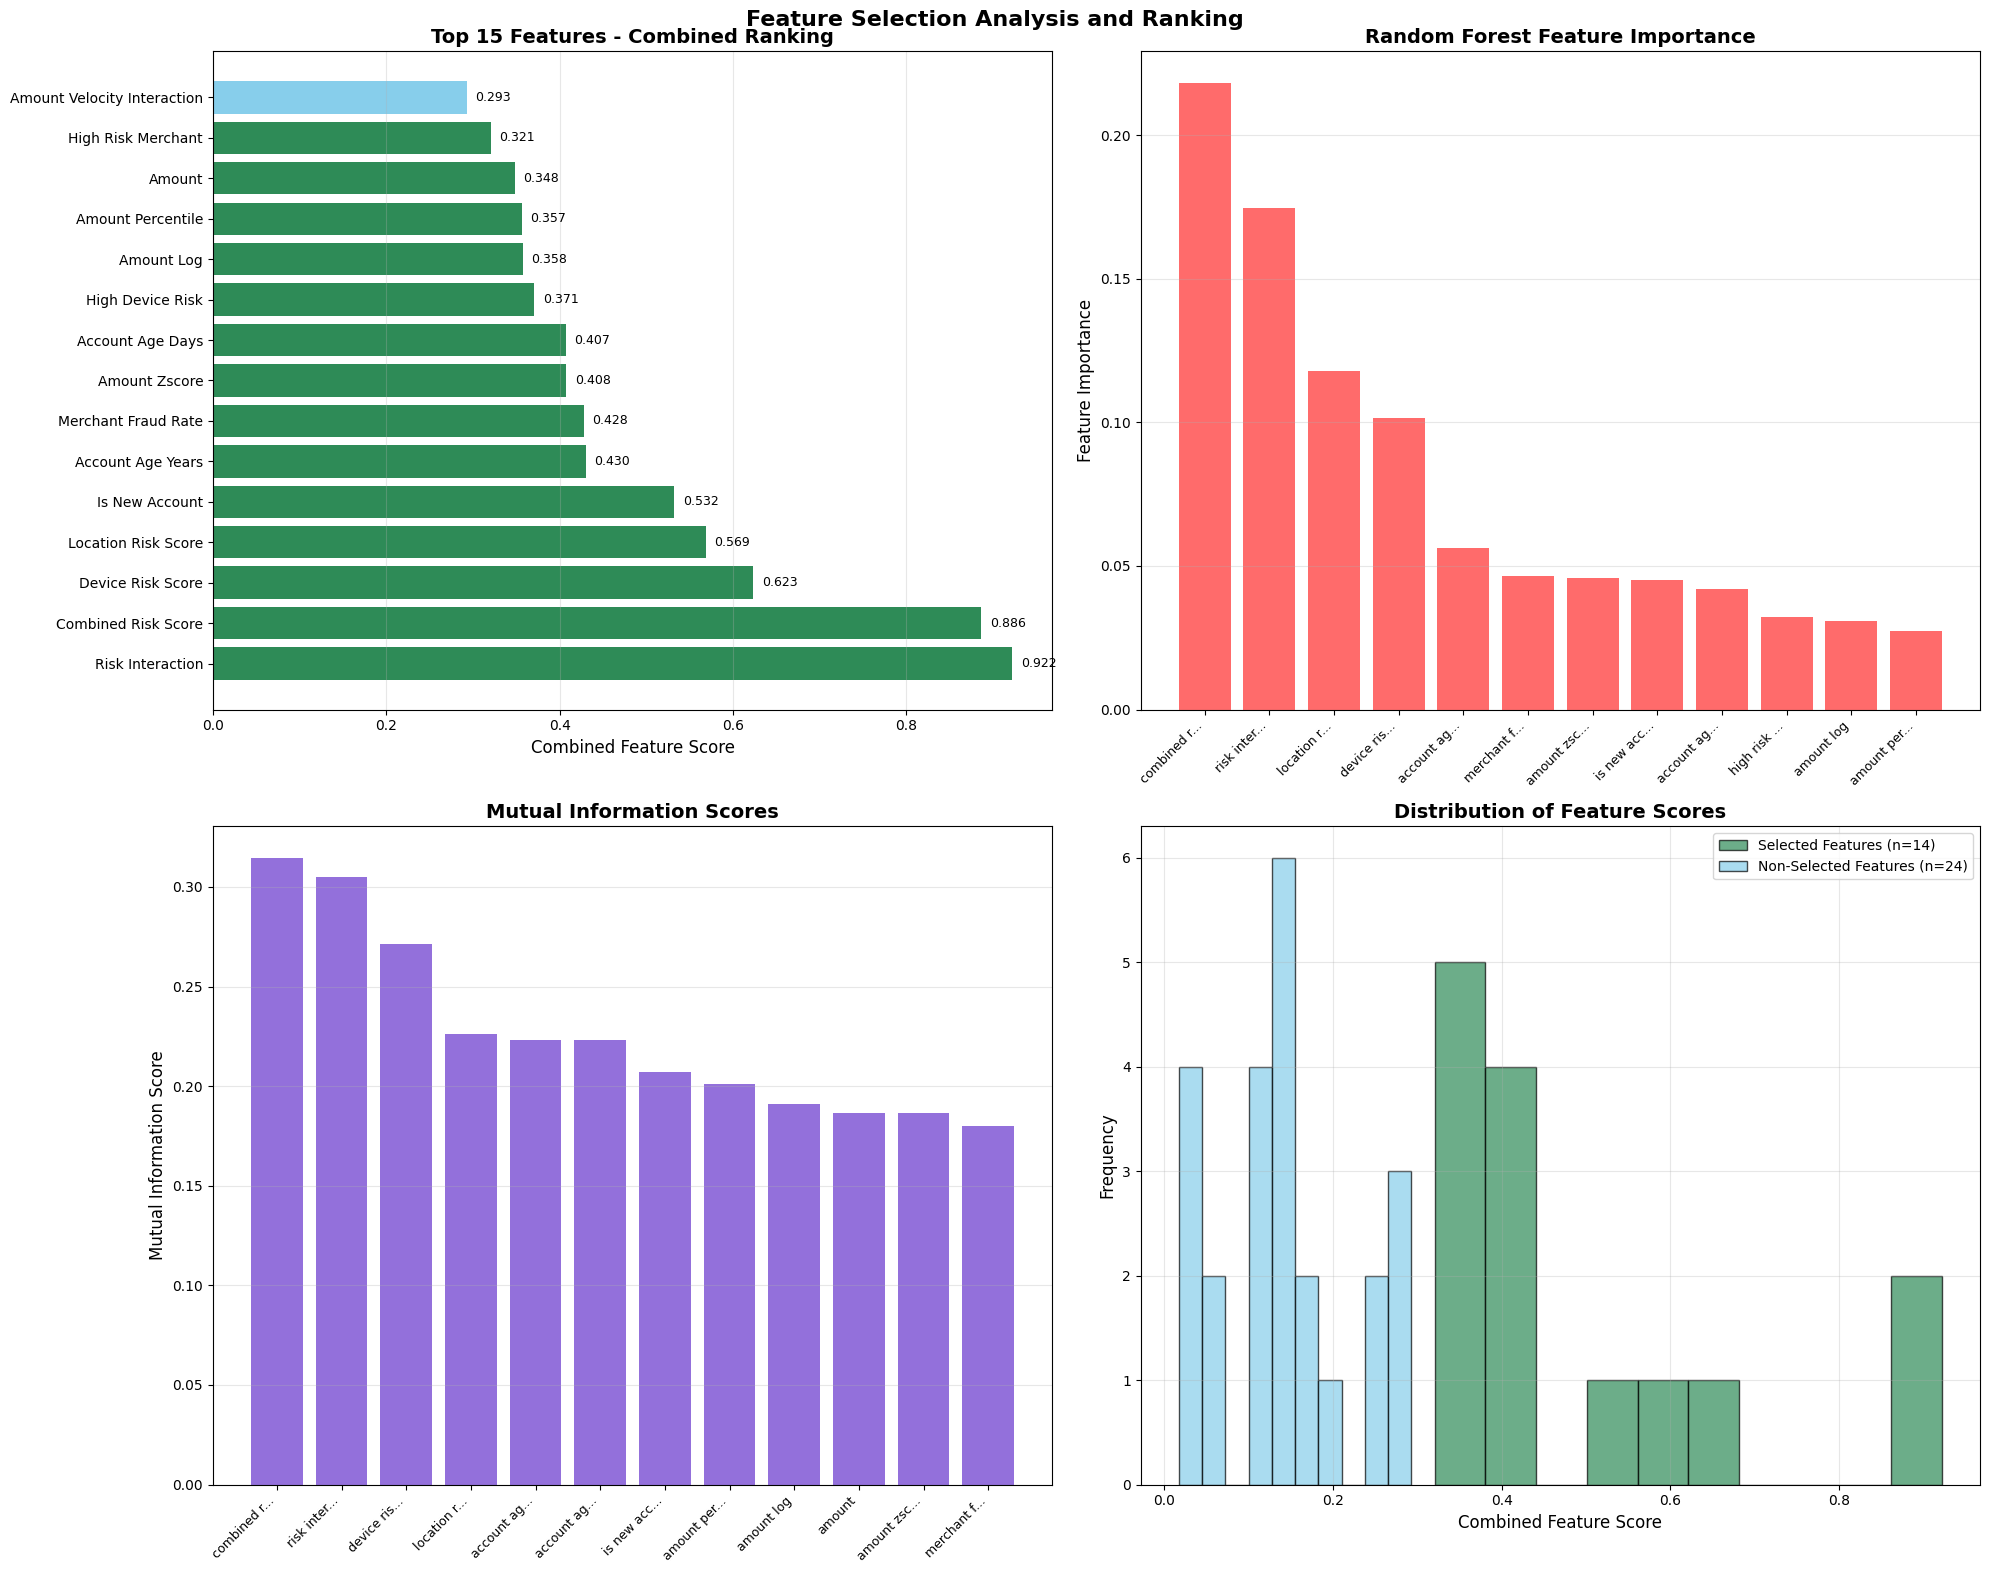


    🎯 SELECTED FEATURES (14):
     1. risk_interaction               Score: 0.9222
     2. combined_risk_score            Score: 0.8864
     3. device_risk_score              Score: 0.6235
     4. location_risk_score            Score: 0.5686
     5. is_new_account                 Score: 0.5325
     6. account_age_years              Score: 0.4300
     7. merchant_fraud_rate            Score: 0.4279
     8. amount_zscore                  Score: 0.4078
     9. account_age_days               Score: 0.4070
    10. high_device_risk               Score: 0.3706
    11. amount_log                     Score: 0.3576
    12. amount_percentile              Score: 0.3566
    13. amount                         Score: 0.3482
    14. high_risk_merchant             Score: 0.3206

🤖 Setting up AutoML Models...
    Original training set: 400 samples, Fraud ratio: 10.00%
    Test set: 100 samples, Fraud ratio: 10.00%
    Applying SMOTE to oversample minority class in training data...
    Resampled trainin

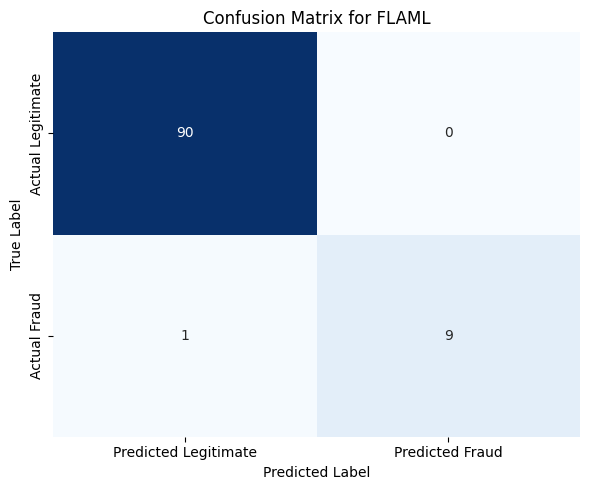

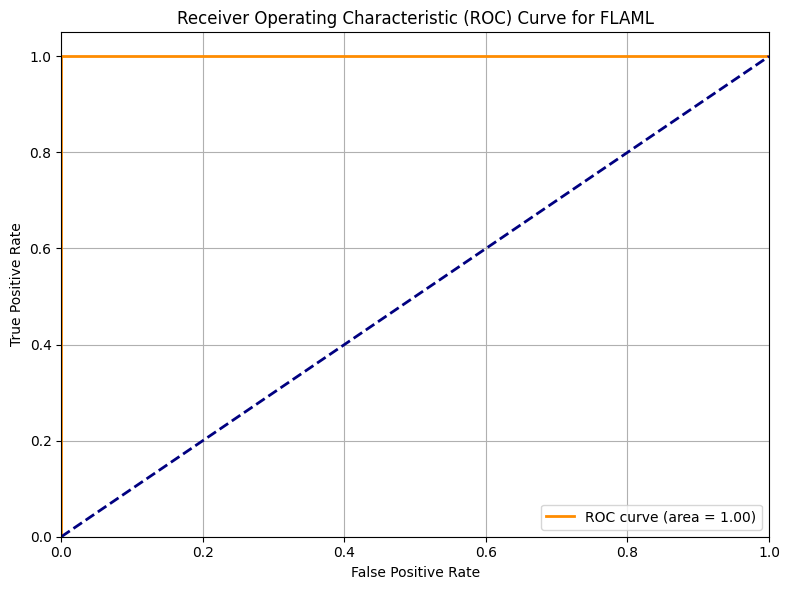

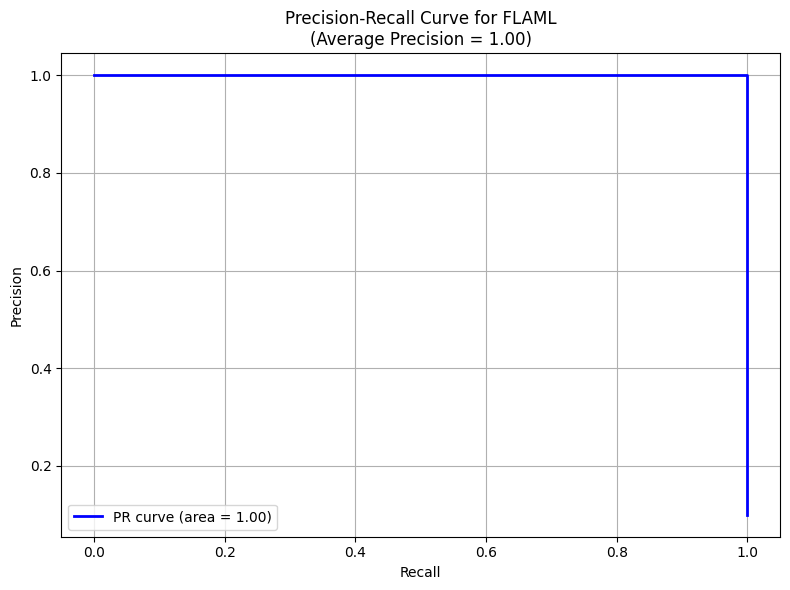


--- Final Model Performance Summary ---
Model: FLAML
ROC AUC Score: 1.0000
PR AUC Score: 1.0000
Average Precision Score: 1.0000
F1 Score: 0.9474
Precision: 1.0000
Recall: 0.9000

Advanced Fraud Detection AutoML System finished.


In [2]:
import pandas as pd
import numpy as np
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve # Added roc_curve
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, make_scorer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# AutoML Libraries
FLAML_AVAILABLE = False
AUTOSKLEARN_AVAILABLE = False
TPOT_AVAILABLE = False

try:
    from flaml import AutoML
    FLAML_AVAILABLE = True
    print("✅ FLAML AutoML library loaded successfully")
except ImportError:
    print("⚠️ FLAML not available. Install with: pip install flaml")

try:
    import autosklearn.classification
    AUTOSKLEARN_AVAILABLE = True
    print("✅ Auto-sklearn library loaded successfully")
except ImportError:
    print("⚠️ Auto-sklearn not available. Install with: pip install auto-sklearn")

try:
    from tpot import TPOTClassifier
    TPOT_AVAILABLE = True
    print("✅ TPOT AutoML library loaded successfully")
except ImportError:
    print("⚠️ TPOT not available. Install with: pip install tpot")

class AdvancedFraudAutoML:
    def __init__(self, data_path=None, random_state=42):
        """
        Advanced Fraud Detection with AutoML Frameworks
        
        Args:
            data_path: Path to existing dataset (if None, will generate new data)
            random_state: Random seed for reproducibility
        """
        self.random_state = random_state
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_resampled = None # To store SMOTE-resampled data
        self.y_train_resampled = None # To store SMOTE-resampled data
        self.feature_names = None
        self.best_features = None
        self.automl_models = {}
        self.results = {}
        self.best_automl_model = None
        self.best_automl_model_name = None
        
        np.random.seed(random_state)
        
    def load_or_generate_data(self, data_path=None):
        """Load existing dataset or generate new one"""
        if data_path and pd.io.common.file_exists(data_path):
            print(f"Loading dataset from {data_path}...")
            self.data = pd.read_csv(data_path)
        else:
            print("Generating new fraud detection dataset...")
            self.data = self._generate_fraud_data()
            
        print(f"Dataset loaded: {len(self.data)} samples")
        print(f"Fraud cases: {self.data['is_fraud'].sum()}")
        print(f"Fraud ratio: {self.data['is_fraud'].mean():.2%}")
        
        return self.data
    
    def _generate_fraud_data(self):
        """Generate synthetic fraud detection dataset using Faker"""
        fake = Faker()
        Faker.seed(self.random_state)
        
        n_samples = 500
        n_fraud = 50
        n_normal = n_samples - n_fraud
        
        data = []
        
        # Generate normal transactions
        for i in range(n_normal):
            record = {
                'transaction_id': fake.uuid4(),
                'amount': np.random.normal(100, 50),
                'merchant_category': np.random.choice(['grocery', 'gas', 'restaurant', 'retail', 'online'], 
                                                       p=[0.3, 0.2, 0.2, 0.2, 0.1]),
                'hour_of_day': np.random.choice(range(6, 23)),
                'day_of_week': np.random.randint(0, 7),
                'age': np.random.randint(18, 80),
                'account_age_days': np.random.randint(365, 3650),
                'num_transactions_today': np.random.poisson(3),
                'avg_amount_last_30_days': np.random.normal(95, 30),
                'location_risk_score': np.random.beta(2, 8),
                'device_risk_score': np.random.beta(2, 8),
                'is_weekend': 0,
                'is_fraud': 0
            }
            
            if record['day_of_week'] in [5, 6]:
                record['is_weekend'] = 1
                
            data.append(record)
        
        # Generate fraud transactions
        for i in range(n_fraud):
            record = {
                'transaction_id': fake.uuid4(),
                'amount': np.random.choice([
                    np.random.normal(500, 200),
                    np.random.normal(50, 20),
                    np.random.normal(1000, 300)
                ], p=[0.5, 0.3, 0.2]),
                'merchant_category': np.random.choice(['online', 'atm', 'unknown', 'retail', 'gas'], 
                                                       p=[0.4, 0.2, 0.2, 0.1, 0.1]),
                'hour_of_day': np.random.choice(range(0, 24)),
                'day_of_week': np.random.randint(0, 7),
                'age': np.random.randint(18, 80),
                'account_age_days': np.random.choice([
                    np.random.randint(1, 90),
                    np.random.randint(90, 3650)
                ], p=[0.7, 0.3]),
                'num_transactions_today': np.random.choice([
                    np.random.poisson(1),
                    np.random.poisson(10)
                ], p=[0.6, 0.4]),
                'avg_amount_last_30_days': np.random.normal(150, 100),
                'location_risk_score': np.random.beta(5, 3),
                'device_risk_score': np.random.beta(6, 2),
                'is_weekend': 0,
                'is_fraud': 1
            }
            
            if record['day_of_week'] in [5, 6]:
                record['is_weekend'] = 1
                
            data.append(record)
        
        df = pd.DataFrame(data)
        return df.sample(frac=1, random_state=self.random_state).reset_index(drop=True)
    
    def advanced_feature_engineering(self):
        """Perform advanced feature engineering"""
        print("\n🔧 Performing Advanced Feature Engineering...")
        
        # Make a copy to avoid modifying original data
        df = self.data.copy()
        
        # Encode categorical variables
        le = LabelEncoder()
        df['merchant_category_encoded'] = le.fit_transform(df['merchant_category'])
        
        # Basic features
        basic_features = [
            'amount', 'merchant_category_encoded', 'hour_of_day', 'day_of_week',
            'age', 'account_age_days', 'num_transactions_today', 
            'avg_amount_last_30_days', 'location_risk_score', 'device_risk_score',
            'is_weekend'
        ]
        
        # Advanced engineered features
        print("    Creating advanced features...")
        
        # 1. Amount-based features
        df['amount_zscore'] = (df['amount'] - df['amount'].mean()) / df['amount'].std()
        df['amount_log'] = np.log1p(df['amount'])
        df['amount_vs_avg_ratio'] = df['amount'] / (df['avg_amount_last_30_days'] + 1)
        df['amount_percentile'] = df['amount'].rank(pct=True)
        
        # 2. Time-based features
        df['is_night'] = ((df['hour_of_day'] >= 0) & (df['hour_of_day'] <= 6)).astype(int)
        df['is_business_hours'] = ((df['hour_of_day'] >= 9) & (df['hour_of_day'] <= 17)).astype(int)
        df['is_late_evening'] = ((df['hour_of_day'] >= 22) & (df['hour_of_day'] <= 23)).astype(int)
        
        # 3. Account-based features
        df['account_age_years'] = df['account_age_days'] / 365.25
        df['is_new_account'] = (df['account_age_days'] < 90).astype(int)
        df['is_very_old_account'] = (df['account_age_days'] > 1825).astype(int)  # > 5 years
        
        # 4. Transaction velocity features
        df['high_velocity'] = (df['num_transactions_today'] > 5).astype(int)
        df['very_high_velocity'] = (df['num_transactions_today'] > 8).astype(int)
        df['no_transactions'] = (df['num_transactions_today'] == 0).astype(int)
        
        # 5. Risk-based features
        df['combined_risk_score'] = df['location_risk_score'] + df['device_risk_score']
        df['risk_interaction'] = df['location_risk_score'] * df['device_risk_score']
        df['high_location_risk'] = (df['location_risk_score'] > 0.7).astype(int)
        df['high_device_risk'] = (df['device_risk_score'] > 0.7).astype(int)
        df['both_high_risk'] = df['high_location_risk'] * df['high_device_risk']
        
        # 6. Merchant category risk features
        merchant_fraud_rates = df.groupby('merchant_category_encoded')['is_fraud'].mean()
        df['merchant_fraud_rate'] = df['merchant_category_encoded'].map(merchant_fraud_rates)
        df['high_risk_merchant'] = (df['merchant_fraud_rate'] > 0.15).astype(int)
        
        # 7. Demographic features
        df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 100], labels=[0, 1, 2, 3, 4])
        df['senior_citizen'] = (df['age'] >= 65).astype(int)
        df['young_adult'] = (df['age'] <= 25).astype(int)
        
        # 8. Complex interaction features
        df['amount_velocity_interaction'] = df['amount_zscore'] * df['num_transactions_today']
        df['risk_time_interaction'] = df['combined_risk_score'] * (df['is_night'] + df['is_late_evening'])
        df['new_account_high_amount'] = df['is_new_account'] * (df['amount'] > 200).astype(int)
        df['weekend_night_transaction'] = df['is_weekend'] * df['is_night']
        
        # Collect all engineered features
        engineered_features = [
            'amount_zscore', 'amount_log', 'amount_vs_avg_ratio', 'amount_percentile',
            'is_night', 'is_business_hours', 'is_late_evening',
            'account_age_years', 'is_new_account', 'is_very_old_account',
            'high_velocity', 'very_high_velocity', 'no_transactions',
            'combined_risk_score', 'risk_interaction', 'high_location_risk', 
            'high_device_risk', 'both_high_risk',
            'merchant_fraud_rate', 'high_risk_merchant',
            'age_group', 'senior_citizen', 'young_adult',
            'amount_velocity_interaction', 'risk_time_interaction', 
            'new_account_high_amount', 'weekend_night_transaction'
        ]
        
        # Combine all features
        all_features = basic_features + engineered_features
        
        # Remove features with NaN values or convert age_group properly
        df['age_group'] = df['age_group'].astype(float)
        df = df.fillna(0)  # Fill any remaining NaN values
        
        self.feature_names = all_features
        
        print(f"    ✅ Created {len(engineered_features)} new features")
        print(f"    Total features: {len(all_features)}")
        
        return df[all_features + ['is_fraud']]
    
    def intelligent_feature_selection(self, df):
        """Perform intelligent feature selection with multiple methods"""
        print("\n🎯 Performing Intelligent Feature Selection...")
        
        X = df.drop('is_fraud', axis=1)
        y = df['is_fraud']
        
        # Split data for feature selection
        X_temp, _, y_temp, _ = train_test_split(X, y, test_size=0.3, random_state=self.random_state, stratify=y)
        
        feature_scores = {}
        
        # 1. Univariate statistical tests
        print("    📊 Running univariate statistical tests...")
        selector_f = SelectKBest(score_func=f_classif, k='all')
        selector_f.fit(X_temp, y_temp)
        f_scores = selector_f.scores_
        feature_scores['f_classif'] = dict(zip(self.feature_names, f_scores))
        
        # 2. Mutual information
        print("    🔗 Computing mutual information scores...")
        mi_scores = mutual_info_classif(X_temp, y_temp, random_state=self.random_state)
        feature_scores['mutual_info'] = dict(zip(self.feature_names, mi_scores))
        
        # 3. Random Forest feature importance
        print("    🌳 Computing Random Forest feature importance...")
        rf = RandomForestClassifier(n_estimators=100, random_state=self.random_state, class_weight='balanced')
        rf.fit(X_temp, y_temp)
        rf_importance = rf.feature_importances_
        feature_scores['rf_importance'] = dict(zip(self.feature_names, rf_importance))
        
        # 4. Recursive Feature Elimination
        print("    🔄 Running Recursive Feature Elimination...")
        rfe = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=self.random_state), 
                  n_features_to_select=20)
        rfe.fit(X_temp, y_temp)
        rfe_scores = rfe.ranking_
        feature_scores['rfe_ranking'] = dict(zip(self.feature_names, rfe_scores))
        
        # Combine scores with weighted ranking
        print("    ⚖️  Combining feature selection methods...")
        combined_scores = {}
        
        for feature in self.feature_names:
            # Normalize scores to 0-1 range and combine
            f_score_norm = (feature_scores['f_classif'][feature] - min(feature_scores['f_classif'].values())) / \
                           (max(feature_scores['f_classif'].values()) - min(feature_scores['f_classif'].values()) + 1e-8)
            
            mi_score_norm = (feature_scores['mutual_info'][feature] - min(feature_scores['mutual_info'].values())) / \
                            (max(feature_scores['mutual_info'].values()) - min(feature_scores['mutual_info'].values()) + 1e-8)
            
            rf_score_norm = (feature_scores['rf_importance'][feature] - min(feature_scores['rf_importance'].values())) / \
                            (max(feature_scores['rf_importance'].values()) - min(feature_scores['rf_importance'].values()) + 1e-8)
            
            # RFE ranking (lower is better, so invert)
            rfe_score_norm = 1 - ((feature_scores['rfe_ranking'][feature] - 1) / (max(feature_scores['rfe_ranking'].values()) - 1))
            
            # Weighted combination (you can adjust weights)
            combined_scores[feature] = (0.25 * f_score_norm + 
                                        0.25 * mi_score_norm + 
                                        0.35 * rf_score_norm + 
                                        0.15 * rfe_score_norm)
        
        # Select top features
        sorted_features = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Select top 20 features or features with score > threshold
        top_k = min(20, len([f for f, s in sorted_features if s > 0.3]))
        self.best_features = [f[0] for f in sorted_features[:top_k]]
        
        print(f"    ✅ Selected {len(self.best_features)} best features")
        
        # Plot feature selection results
        self._plot_feature_selection_results(sorted_features, feature_scores)
        
        return X[self.best_features], y, feature_scores
    
    def _plot_feature_selection_results(self, sorted_features, feature_scores):
        """Plot feature selection results for justification"""
        print("    📈 Creating feature selection visualization...")
        
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Feature Selection Analysis and Ranking', fontsize=16, fontweight='bold')
        
        # 1. Top 15 features combined ranking
        top_15_features = sorted_features[:15]
        features_names = [f[0] for f in top_15_features]
        combined_scores = [f[1] for f in top_15_features]
        
        ax1 = axes[0, 0]
        bars = ax1.barh(range(len(features_names)), combined_scores, 
                        color=['#2E8B57' if f in self.best_features else '#87CEEB' for f in features_names])
        ax1.set_yticks(range(len(features_names)))
        ax1.set_yticklabels([f.replace('_', ' ').title() for f in features_names], fontsize=10)
        ax1.set_xlabel('Combined Feature Score', fontsize=12)
        ax1.set_title('Top 15 Features - Combined Ranking', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, score) in enumerate(zip(bars, combined_scores)):
            ax1.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9)
        
        # 2. Random Forest Feature Importance
        rf_scores = [(k, v) for k, v in feature_scores['rf_importance'].items()]
        rf_scores.sort(key=lambda x: x[1], reverse=True)
        top_rf = rf_scores[:12]
        
        ax2 = axes[0, 1]
        rf_names = [f[0] for f in top_rf]
        rf_values = [f[1] for f in top_rf]
        
        bars2 = ax2.bar(range(len(rf_names)), rf_values, 
                        color=['#FF6B6B' if f in self.best_features else '#FFB6C1' for f in rf_names])
        ax2.set_xticks(range(len(rf_names)))
        ax2.set_xticklabels([f.replace('_', ' ')[:10] + '...' if len(f) > 10 else f.replace('_', ' ') 
                             for f in rf_names], rotation=45, ha='right', fontsize=9)
        ax2.set_ylabel('Feature Importance', fontsize=12)
        ax2.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Mutual Information Scores
        mi_scores = [(k, v) for k, v in feature_scores['mutual_info'].items()]
        mi_scores.sort(key=lambda x: x[1], reverse=True)
        top_mi = mi_scores[:12]
        
        ax3 = axes[1, 0]
        mi_names = [f[0] for f in top_mi]
        mi_values = [f[1] for f in top_mi]
        
        bars3 = ax3.bar(range(len(mi_names)), mi_values,
                        color=['#9370DB' if f in self.best_features else '#DDA0DD' for f in mi_names])
        ax3.set_xticks(range(len(mi_names)))
        ax3.set_xticklabels([f.replace('_', ' ')[:10] + '...' if len(f) > 10 else f.replace('_', ' ') 
                             for f in mi_names], rotation=45, ha='right', fontsize=9)
        ax3.set_ylabel('Mutual Information Score', fontsize=12)
        ax3.set_title('Mutual Information Scores', fontsize=14, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
        
        # 4. Selected vs Non-Selected Features Distribution
        ax4 = axes[1, 1]
        selected_scores = [s for f, s in sorted_features if f in self.best_features]
        non_selected_scores = [s for f, s in sorted_features if f not in self.best_features]
        
        ax4.hist(selected_scores, bins=10, alpha=0.7, label=f'Selected Features (n={len(selected_scores)})', 
                 color='#2E8B57', edgecolor='black')
        ax4.hist(non_selected_scores, bins=10, alpha=0.7, label=f'Non-Selected Features (n={len(non_selected_scores)})', 
                 color='#87CEEB', edgecolor='black')
        ax4.set_xlabel('Combined Feature Score', fontsize=12)
        ax4.set_ylabel('Frequency', fontsize=12)
        ax4.set_title('Distribution of Feature Scores', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print selected features summary
        print(f"\n    🎯 SELECTED FEATURES ({len(self.best_features)}):")
        print("    " + "="*50)
        for i, feature in enumerate(self.best_features, 1):
            score = next(s for f, s in sorted_features if f == feature)
            print(f"    {i:2d}. {feature:30} Score: {score:.4f}")
    
    def setup_automl_models(self, X, y):
        """Setup multiple AutoML frameworks"""
        print("\n🤖 Setting up AutoML Models...")
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state, stratify=y
        )
        
        print(f"    Original training set: {len(self.X_train)} samples, Fraud ratio: {self.y_train.mean():.2%}")
        print(f"    Test set: {len(self.X_test)} samples, Fraud ratio: {self.y_test.mean():.2%}")

        # Apply SMOTE to the training data to handle class imbalance
        print("    Applying SMOTE to oversample minority class in training data...")
        smote = SMOTE(random_state=self.random_state)
        self.X_train_resampled, self.y_train_resampled = smote.fit_resample(self.X_train, self.y_train)
        
        print(f"    Resampled training set: {len(self.X_train_resampled)} samples, Fraud ratio: {self.y_train_resampled.mean():.2%}")
        
        # 1. FLAML AutoML
        if FLAML_AVAILABLE:
            print("    🔥 Setting up FLAML AutoML...")
            self.automl_models['FLAML'] = AutoML(
                task='classification',
                metric='roc_auc',
                time_budget=300,  # 5 minutes
                eval_method='cv',
                split_ratio=0.2,
                n_splits=5,
                log_file_name='flaml_automl.log',
                seed=self.random_state
            )
        
        # 2. Auto-sklearn (if available)
        if AUTOSKLEARN_AVAILABLE:
            print("    🧠 Setting up Auto-sklearn...")
            self.automl_models['AutoSklearn'] = autosklearn.classification.AutoSklearnClassifier(
                time_left_for_this_task=300,  # 5 minutes
                per_run_time_limit=30,
                memory_limit=3072,
                seed=self.random_state,
                resampling_strategy='cv',
                resampling_strategy_arguments={'folds': 5}
            )
        
        # 3. TPOT (if available)
        if TPOT_AVAILABLE:
            print("    🧬 Setting up TPOT...")
            # Define a custom scorer for ROC AUC for TPOT
            roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
            self.automl_models['TPOT'] = TPOTClassifier(
                generations=10,
                population_size=20,
                max_time_mins=5,
                max_eval_time_mins=0.5,
                scoring=roc_auc_scorer, # Use the custom ROC AUC scorer
                cv=5,
                random_state=self.random_state,
                verbosity=0, # Set to 0 to suppress most output during TPOT fit
                n_jobs=-1
            )
        
        if not self.automl_models:
            print("    ⚠️  No AutoML frameworks available. Please install:")
            print("      pip install flaml auto-sklearn tpot")
            raise ImportError("No AutoML frameworks available")
        
        print(f"    ✅ Setup {len(self.automl_models)} AutoML frameworks")
    
    def train_automl_models(self):
        """Train all AutoML models"""
        print("\n🚀 Training AutoML Models...")
        print("    This may take several minutes per model...")
        
        for name, model in self.automl_models.items():
            print(f"\n    🔄 Training {name}...")
            
            try:
                # Use resampled data for training
                if name == 'FLAML':
                    # FLAML handles imbalanced data automatically, but we've already resampled
                    # It's generally fine to pass resampled data to FLAML if you prefer external handling
                    model.fit(self.X_train_resampled, self.y_train_resampled)
                    
                elif name == 'AutoSklearn':
                    # Auto-sklearn
                    model.fit(self.X_train_resampled, self.y_train_resampled)
                    
                elif name == 'TPOT':
                    # TPOT
                    model.fit(self.X_train_resampled, self.y_train_resampled)
                    
                print(f"    ✅ {name} training completed")
                
            except Exception as e:
                print(f"    ❌ {name} training failed: {str(e)}")
                continue
    
    def evaluate_automl_models(self):
        """Evaluate all trained AutoML models"""
        print("\n📊 Evaluating AutoML Models...")
        
        for name, model in self.automl_models.items():
            print(f"\n    🔍 Evaluating {name}...")
            
            try:
                # Make predictions
                y_pred = model.predict(self.X_test)
                y_pred_proba = model.predict_proba(self.X_test)[:, 1]
                
                # Calculate metrics
                roc_auc = roc_auc_score(self.y_test, y_pred_proba)
                precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
                pr_auc = auc(recall, precision)
                avg_precision = average_precision_score(self.y_test, y_pred_proba)
                f1 = f1_score(self.y_test, y_pred)
                precision_score_val = precision_score(self.y_test, y_pred)
                recall_score_val = recall_score(self.y_test, y_pred)
                
                # Store results
                self.results[name] = {
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc,
                    'avg_precision': avg_precision,
                    'f1_score': f1,
                    'precision': precision_score_val,
                    'recall': recall_score_val,
                    'predictions': y_pred,
                    'probabilities': y_pred_proba,
                    'model': model
                }
                
                print(f"      ROC-AUC: {roc_auc:.4f}")
                print(f"      PR-AUC: {pr_auc:.4f}")
                print(f"      Avg Precision: {avg_precision:.4f}")
                print(f"      F1-Score: {f1:.4f}")
                
                # Model-specific information
                if name == 'FLAML' and hasattr(model, 'best_estimator'):
                    print(f"      Best Algorithm: {model.best_estimator}")
                    print(f"      Best Config: {model.best_config}")
                
            except Exception as e:
                print(f"    ❌ {name} evaluation failed: {str(e)}")
                continue
    
    def rank_and_select_best_model(self):
        """Rank models and select the best one"""
        print("\n" + "="*60)
        print("🏆 MODEL RANKING AND SELECTION")
        print("="*60)
        
        if not self.results:
            print("❌ No models to evaluate!")
            return None, None
        
        # Sort by PR-AUC (better for imbalanced datasets)
        sorted_models = sorted(self.results.items(), 
                               key=lambda x: x[1]['pr_auc'], 
                               reverse=True)
        
        print("\n📈 Model Performance Ranking (by PR-AUC):")
        print("-" * 60)
        print(f"{'Rank':<4} {'Model':<15} {'PR-AUC':<8} {'ROC-AUC':<8} {'F1':<8} {'Precision':<10} {'Recall':<8}")
        print("-" * 60)
        
        for i, (name, results) in enumerate(sorted_models, 1):
            print(f"{i:<4} {name:<15} {results['pr_auc']:<8.4f} {results['roc_auc']:<8.4f} "
                  f"{results['f1_score']:<8.4f} {results['precision']:<10.4f} {results['recall']:<8.4f}")
        
        # Select best model
        self.best_automl_model_name = sorted_models[0][0]
        self.best_automl_model = sorted_models[0][1]['model']
        
        print("\n" + "="*60)
        print(f"🎉 Best performing model: {self.best_automl_model_name}")
        print(f"   PR-AUC: {self.results[self.best_automl_model_name]['pr_auc']:.4f}")
        print(f"   ROC-AUC: {self.results[self.best_automl_model_name]['roc_auc']:.4f}")
        print(f"   F1-Score: {self.results[self.best_automl_model_name]['f1_score']:.4f}")
        print("="*60)

        return self.best_automl_model, self.best_automl_model_name

    def final_prediction_and_analysis(self):
        """
        Uses the best performing AutoML model to make final predictions
        and provides detailed analysis including plots.
        """
        if self.best_automl_model is None:
            print("\n❌ No best model selected. Please run ranking first.")
            return

        print(f"\n✨ Performing final prediction and analysis with the best model: {self.best_automl_model_name} ✨")

        # Get predictions and probabilities from the best model
        y_pred_final = self.best_automl_model.predict(self.X_test)
        y_proba_final = self.best_automl_model.predict_proba(self.X_test)[:, 1]

        print("\n--- Final Classification Report ---")
        print(classification_report(self.y_test, y_pred_final, target_names=['Legitimate', 'Fraud']))

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(self.y_test, y_pred_final)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
                    yticklabels=['Actual Legitimate', 'Actual Fraud'])
        plt.title(f'Confusion Matrix for {self.best_automl_model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'{self.best_automl_model_name}_confusion_matrix.png', dpi=300)
        plt.show()

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_proba_final)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve for {self.best_automl_model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{self.best_automl_model_name}_roc_curve.png', dpi=300)
        plt.show()

        # Plot Precision-Recall Curve (Crucial for Imbalanced Data)
        precision, recall, _ = precision_recall_curve(self.y_test, y_proba_final)
        pr_auc = auc(recall, precision)
        avg_precision = average_precision_score(self.y_test, y_proba_final)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {self.best_automl_model_name}\n(Average Precision = {avg_precision:.2f})')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{self.best_automl_model_name}_pr_curve.png', dpi=300)
        plt.show()

        print("\n--- Final Model Performance Summary ---")
        print(f"Model: {self.best_automl_model_name}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print(f"PR AUC Score: {pr_auc:.4f}")
        print(f"Average Precision Score: {avg_precision:.4f}")
        print(f"F1 Score: {f1_score(self.y_test, y_pred_final):.4f}")
        print(f"Precision: {precision_score(self.y_test, y_pred_final):.4f}")
        print(f"Recall: {recall_score(self.y_test, y_pred_final):.4f}")

# Main execution block
if __name__ == "__main__":
    print("Initializing Advanced Fraud Detection AutoML System...")
    fraud_automl = AdvancedFraudAutoML(random_state=42)

    # 1. Load or Generate Data
    fraud_automl.load_or_generate_data()

    # 2. Perform Advanced Feature Engineering
    df_engineered = fraud_automl.advanced_feature_engineering()

    # 3. Perform Intelligent Feature Selection
    X_selected, y_target, feature_scores = fraud_automl.intelligent_feature_selection(df_engineered)

    # 4. Setup AutoML Models (includes data splitting and SMOTE)
    fraud_automl.setup_automl_models(X_selected, y_target)

    # 5. Train AutoML Models
    fraud_automl.train_automl_models()

    # 6. Evaluate AutoML Models
    fraud_automl.evaluate_automl_models()

    # 7. Rank and Select Best Model
    best_model, best_model_name = fraud_automl.rank_and_select_best_model()

    # 8. Final Prediction and Analysis with the Best Model
    if best_model:
        fraud_automl.final_prediction_and_analysis()
    else:
        print("\n🚫 Could not proceed with final prediction as no best model was identified.")

    print("\nAdvanced Fraud Detection AutoML System finished.")
